In [1]:
# Imports
import sys
sys.path.insert(1, '../')
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import uproot
import pickle
import analysis.vector as vector
import analysis.Master as Master
import time

In [2]:
# Functions

# This is a memory management tool, currently not realyl necessary
def del_prop(obj, property_name):
    del(obj.__dict__["_RecoPairData__" + property_name])
    return

# Hopefully this is correct, not tested yet though!
# I fear it may require iterating through events to calculate though
def get_beam_impact_point(direction, start_pos, beam_vertex):
    rel_pos = vector.sub(beam_vertex, start_pos)
    cross = vector.cross(rel_pos, direction)
    return vector.magnitude(cross)

In [3]:
# Edit the base classes to fit what we want to be doing with pairs
class RecoPairData(Master.RecoParticleData):
    @property
    def pandoraTag(self):
        self.LoadData("pandoraTag", "pandoraTag")
        return getattr(self, f"_{type(self).__name__}__pandoraTag")

    @property
    def cnnScore(self):
        self.LoadData("cnnScore", "CNNScore_collection")
        return getattr(self, f"_{type(self).__name__}__cnnScore")

class PairData(Master.Data):
    def __init__(self, _filename : str = None, includeBackTrackedMC : bool = False, _nEvents : int = -1, _start : int = 0) -> None:
        super().__init__(_filename, includeBackTrackedMC, _nEvents, _start)
        if self.filename != None:
            self.recoParticles = RecoPairData(self) # Set the reco particles as Pairs to inlucde pandora tag and CNN score
    
    # # Old method, now using Shyam's updated method instead
    # def ApplyBeamTypeFilter(self, beam_pdg):
    #     """ Applies a beam filter to the sample, which selects events
    #         which have a beam particle with the supplied pdg code.
    #     """
    #     if self.recoParticles.beam_number is None:
    #         print("data doesn't contain beam number, can't apply filter.")
    #         return
    #     hasBeam = self.recoParticles.beam_number != -999 # check if event has a beam particle
    #     hasBeam = np.logical_and(self.recoParticles.beamVertex.x != -999, hasBeam)

    #     beamParticle = self.recoParticles.number == self.recoParticles.beam_number # get beam particle
    #     del_prop(self.recoParticles, "number")
    #     self.beamParticleDaughters = self.recoParticles.mother == self.recoParticles.beam_number # get daugter of beam particle
    #     del_prop(self.recoParticles, "beam_number")
    #     del_prop(self.recoParticles, "mother")
        
    #     beam_type_mask = ak.all(self.trueParticlesBT.pdg[beamParticle] == beam_pdg, -1)
    #     # combine masks
    #     # particle_mask = np.logical_or(beamParticle, beamParticleDaughters)
    #     #? which one to do?
    #     self.Filter([hasBeam, beam_type_mask[hasBeam]], [hasBeam, beam_type_mask[hasBeam]]) # filter data
    #     # self.Filter([hasBeam, particle_mask[hasBeam]], [hasBeam]) # filter data

In [4]:
# Load the events (ETA ~1min for a single 6GeV beam v2 sample). ETA ~10s
events = PairData("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

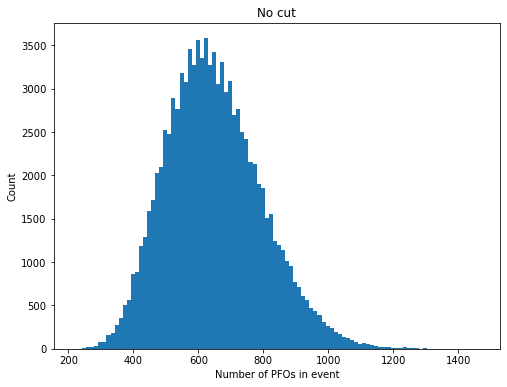

/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to _RecoPairData__beam_number.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to _RecoPairData__beamVertex.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-analysis/notebooks/../analysis/Master.py:52: UserWarning: Couldn't apply filters to eventNum.
  warnings.warn(f"Couldn't apply filters to {var}.")
/users/wx21978/projects/pion-phys/pi0-ana

'ApplyBeamFilter' executed in 35.2962s
beam done in 35.297489404678345s


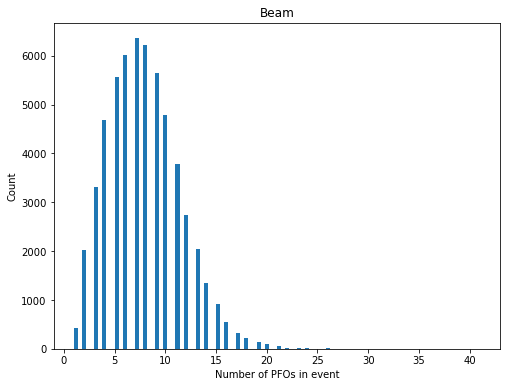

pi+ beam done in 0.019220590591430664s


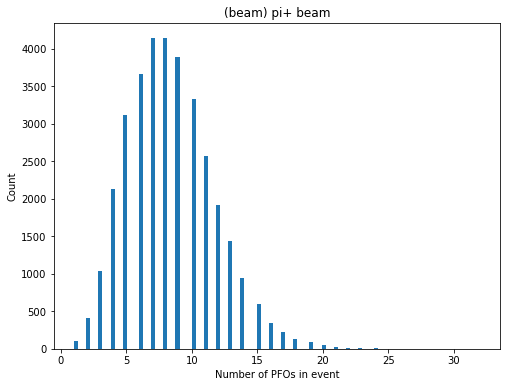

CNNScore > 0.36 done in 13.78114366531372s


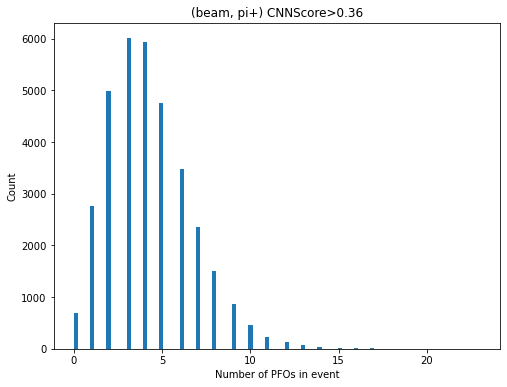

PFOs >= 2 done in 85.16095089912415s


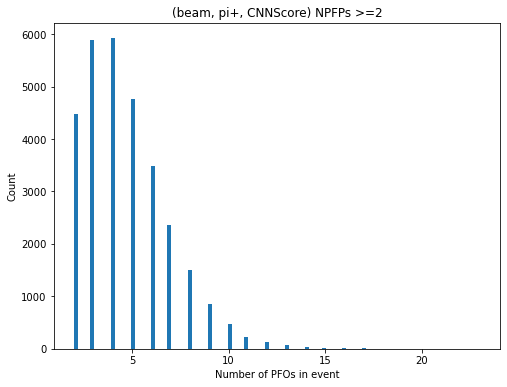

['Event selection', 'Number of PFOs', 'Average PFOs per event', 'Number of events', 'Percentage of events removed']
['no selection', 64987977, 100222, '-']
['beam', 449429, 7.8393336821908255, 57330, 42.79699068068887]
['pi+ beam', 288632, 8.411003613474763, 34316, -437641.28505281144]
['CNNScore > 0.36', 146077, 4.256818976570696, 34316, -407889.36223287793]
['nPFP >= 2', 141863, 4.696828234670905, 30204, -709443.9145108401]


In [5]:
# Apply cuts:
n = [["Event selection", "Number of PFOs", "Average PFOs per event", "Number of events", "Percentage of events removed"]]
n.append(["no selection", ak.count(events.trueParticlesBT.pdg), ak.count(events.eventNum), "-"])

plt.figure(figsize=(8,6))
plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("No cut")
plt.show()

# # Require a beam particle to exist. ETA ~60s:
# ts = time.time()
# events.ApplyBeamTypeFilter(211)
# print(f"pi+ beam done in {time.time()  - ts}s")
# evt_remaining = ak.count(events.eventNum)
# n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Require a beam particle to exist. ETA ~40s:
ts = time.time()
events.ApplyBeamFilter() # apply beam filter if possible
print(f"beam done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

plt.figure(figsize=(8,6))
plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("Beam")
plt.show()

# Require pi+ beam. ETA ~0.01s
ts = time.time()
true_beam = events.trueParticlesBT.pdg[events.recoParticles.beam_number == events.recoParticles.number]
f = ak.all(true_beam == 211, -1)
events.Filter([f], [f])
del(true_beam)
print(f"pi+ beam done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["pi+ beam", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

plt.figure(figsize=(8,6))
plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("(beam) pi+ beam")
plt.show()

# # Only look at PFOs with > 50 hits. ETA ~30s:
# ts = time.time()
# events.Filter([events.recoParticles.nHits > 50], [])
# del_prop(events.recoParticles, "nHits")
# print(f"Hits > 50 done in {time.time()  - ts}s")
# evt_remaining = ak.count(events.eventNum)
# n.append(["nHits >= 51", ak.count(events.trueParticlesBT.pdg), evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

# Take CNNScore > 0.36. ETA ~30s:
cnn_cut = 0.36
ts = time.time()
events.Filter([events.recoParticles.cnnScore > cnn_cut], [])
del_prop(events.recoParticles, "cnnScore")
print(f"CNNScore > 0.36 done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append([f"CNNScore > {cnn_cut}", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

plt.figure(figsize=(8,6))
plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("(beam, pi+) CNNScore>0.36")
plt.show()

# Require >= 2 PFOs. ETA ~120s=2mins:
ts = time.time()
f = Master.NPFPMask(events, -1)
del_prop(events.recoParticles, "direction")
del_prop(events.recoParticles, "startPos")
events.Filter([f], [f])
print(f"PFOs >= 2 done in {time.time()  - ts}s")
evt_remaining = ak.count(events.eventNum)
n.append(["nPFP >= 2", ak.count(events.trueParticlesBT.pdg), ak.count(events.trueParticlesBT.pdg)/evt_remaining, evt_remaining, 100*(n[-1][2] - evt_remaining)/n[-1][2]])

plt.figure(figsize=(8,6))
plt.hist(ak.count(events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("(beam, pi+, CNNScore) NPFPs >=2")
plt.show()

print("\n".join([str(l) for l in n]))

In [6]:
# Signal:
# # # Get IDs of pions from beam
# # beam_pi0 = np.logical_and(events.trueParticlesBT.pdg == 211, events.recoParticles.beamParticleDaughters)
# # # Get IDs of photons from beam
# # pi0_photons = np.logical_and(events.trueParticlesBT.pdg == 22, events.recoParticles.mother == events.recoParticles.number[beam_pi0])
# # # Get shower with mother = id'ed photons

# pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# f = events.trueParticlesBT.mother == pi0

# # ETA ~xs:
# true_photons = ak.flatten(events.trueParticles.number[events.trueParticles.truePhotonMask])
# # pi0 = ak.flatten(events.trueParticles.number[events.trueParticles.PrimaryPi0Mask])
# true_photon_mask = events.trueParticlesBT.number == true_photons

# signal_impacts = get_beam_impact_point(events.recoParticles.direction[true_photon_mask], events.recoParticles.startPos[true_photon_mask], events.beamVertex)

# # Bkg:
# # Not beam
# non_beam_filter = events.trueParticlesBT.number != events.recoParticles.beam_number
# # and not true photon
# bkg_pfos = np.logical_and(non_beam_filter, np.logical_not(true_photon_mask))
# del(non_beam_filter)

# bkg_impacts = get_beam_impact_point(events.recoParticles.direction[true_photons], events.recoParticles.startPos[true_photons], events.beamVertex)


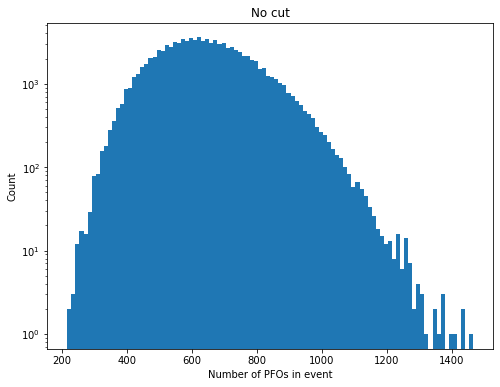

/tmp/ipykernel_3745884/2604054081.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


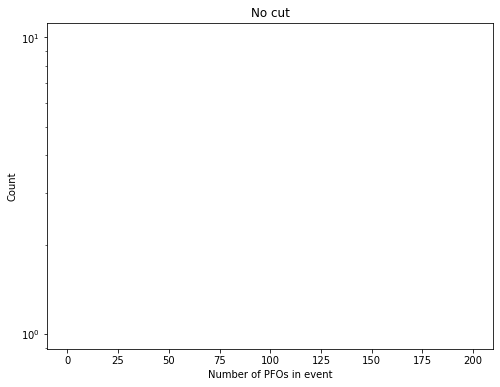

In [8]:
# uncut_events = PairData("/scratch/wx21978/pi0/root_files/6GeV_beam_v1/Prod4a_6GeV_BeamSim_00.root", includeBackTrackedMC=True)

plt.figure(figsize=(8,6))
plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100)
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("No cut")
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,6))
plt.hist(ak.count(uncut_events.trueParticlesBT.pdg, axis=-1), bins=100, range=(0,200))
plt.xlabel("Number of PFOs in event")
plt.ylabel("Count")
plt.title("No cut")
plt.yscale('log')
plt.show()

# print(ak.count(events.eventNum))
# print(ak.count(events.recoParticles.number))
# print(ak.count(events.trueParticlesBT.number))
# print(ak.count(events.trueParticles.number))
# print(np.unique(ak.flatten(events.trueParticles.pdg), return_counts=True))
# print(ak.count(uncut_events.eventNum))
# print(ak.count(uncut_events.recoParticles.number))
# print(ak.count(uncut_events.trueParticlesBT.number))
# print(ak.count(uncut_events.trueParticles.number))
# print(np.unique(ak.flatten(uncut_events.trueParticles.pdg), return_counts=True))

In [8]:
# mother_ids = events.recoParticles.mother
# photons = events.trueParticlesBT.pdg == 22 # PFP is a photon
# pi0_ids = events.trueParticles.number[events.trueParticles.pdg == 111] # get all pi0s
# m = ak.Array([ ak.any( ak.unflatten(events.trueParticlesBT.mother[i], 1, -1) == pi0_ids[i], -1 ) for i in range(nEvents) ]) # ID of mother is in the pi^0 IDs

# ETA ~7mins:
# This loops through every event and assigned the pdg code of the mother.
# Assigns 211 (pi+) to daughters of the beam, and 0 to everything which is not found
mother_ids = events.trueParticlesBT.mother
truth_ids = events.trueParticles.number
truth_pdgs = events.trueParticles.pdg
mother_pdgs = mother_ids.to_list()
ts = time.time()
for i in range(ak.count(events.eventNum)):
    true_pdg_lookup = {truth_ids[i][d]:truth_pdgs[i][d] for d in range(ak.count(truth_ids[i]))}
    true_pdg_lookup.update({0:0, 1:211})
    for j in range(ak.count(mother_ids[i])):
        try:
            mother_pdgs[i][j] = true_pdg_lookup[mother_ids[i][j]]
        except:
            mother_pdgs[i][j] = 0

print(f"All events done in {time.time()  - ts}s")
mother_pdgs = ak.Array(mother_pdgs)
print(mother_pdgs)

# Clean-up variables
del mother_ids
del truth_ids
del truth_pdgs


All events done in 405.2318022251129s
[[111, 111, 111, 111, 111], [111, 0, 111], ... 211, 211], [111, 0, 111], [111, 0]]


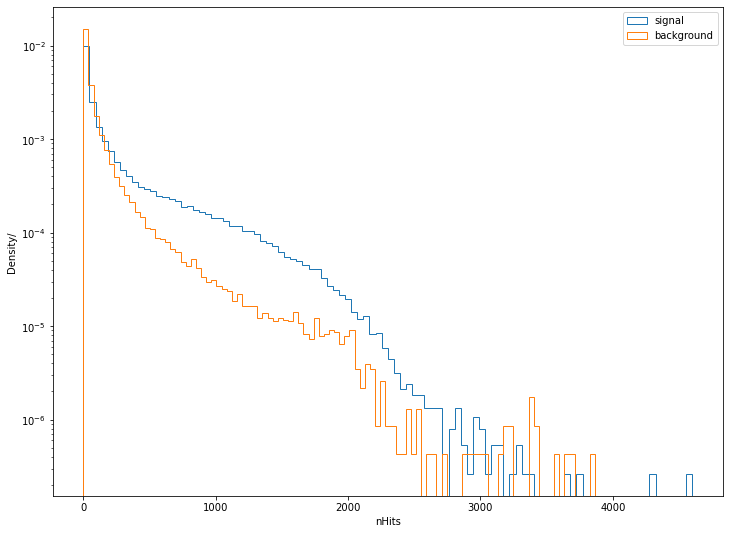

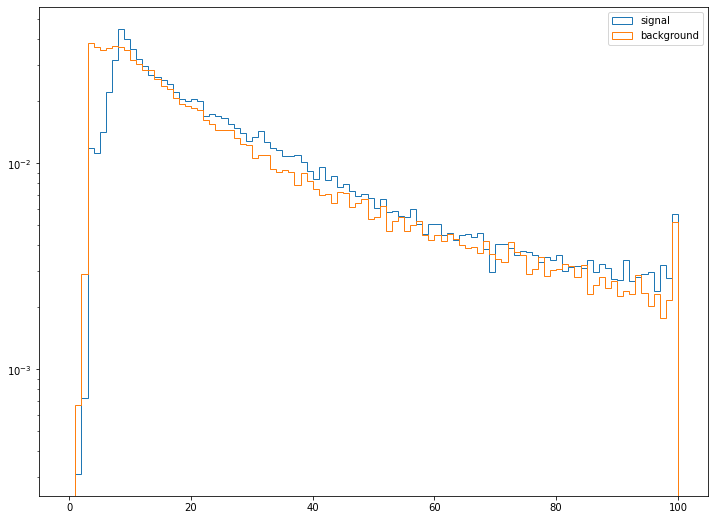

In [9]:
# Plots of nHits. Do we want to make a cut on this as some point, I think probably not, unless we choose low: ~ nHits>7
plt.figure(figsize=(12,9))
plt.hist(ak.ravel(events.recoParticles.nHits[np.logical_and(events.trueParticlesBT.pdg == 22, mother_pdgs == 111)]), bins=100, histtype='step', density=True, label="signal")
plt.hist(ak.ravel(events.recoParticles.nHits[np.logical_not(np.logical_and(events.trueParticlesBT.pdg == 22, mother_pdgs == 111))]), bins=100, histtype='step', density=True, label="background")
plt.yscale('log')
plt.xlabel("nHits")
plt.ylabel("Density")
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(events.recoParticles.nHits[np.logical_and(events.trueParticlesBT.pdg == 22, mother_pdgs == 111)]), range=(0,100), bins=100, histtype='step', density=True, label="signal")
plt.hist(ak.ravel(events.recoParticles.nHits[np.logical_not(np.logical_and(events.trueParticlesBT.pdg == 22, mother_pdgs == 111))]), range=(0,100), bins=100, histtype='step', density=True, label="background")
plt.yscale('log')
plt.xlabel("nHits")
plt.ylabel("Density")
plt.legend()
plt.show()

In [15]:
# Basic method: We come up with a set of pairs.
# Argcombinations give the results as indicies, so we don't have to worry about
# making sure combinations is consistent  between calls.
# Now we just need to use these pair indicies to locate our pairs and do stuff with them
pair_coords = ak.argcombinations(events.recoParticles.number, 2)

# Number of signals in a pair
def paired_sig_count(pair_coords):
    # Get the locations wehere the pdg is 22 and mother pdg is 111
    first_sigs = np.logical_and(events.trueParticlesBT.pdg[pair_coords["0"]] == 22, mother_pdgs[pair_coords["0"]] == 111)
    # Multiplying by 1 sets the dtype to be int (1 where True, 0 where False)
    first_sigs = np.multiply(first_sigs, 1)

    #Same for second particle
    second_sigs = np.logical_and(events.trueParticlesBT.pdg[pair_coords["1"]] == 22, mother_pdgs[pair_coords["1"]] == 111)
    second_sigs = np.multiply(second_sigs, 1)

    # Add the results
    return first_sigs + second_sigs

sig_count = paired_sig_count(pair_coords)


In [ ]:
"""
SUMMARY OF FOLLOWING CELLS

The following cells contain the following properties:
- mass
- closest approach
- energy
- momentum

Long story short, none of them are very good...
I'm hoping a beam vertex impact parameter (see second cell of notebook)
might do alright, but I'm not hopeful. We may need to come up with a
method to find 1 true best leading pair per event (Shyam already has this?)
to do a more refined search.
"""

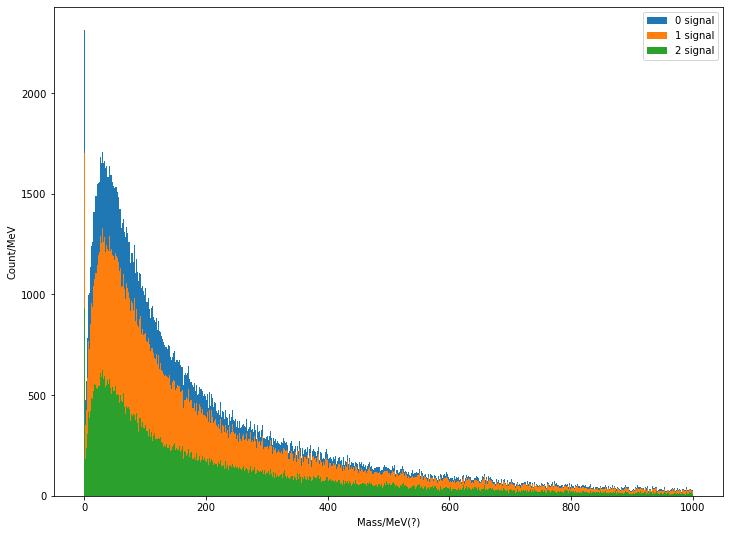

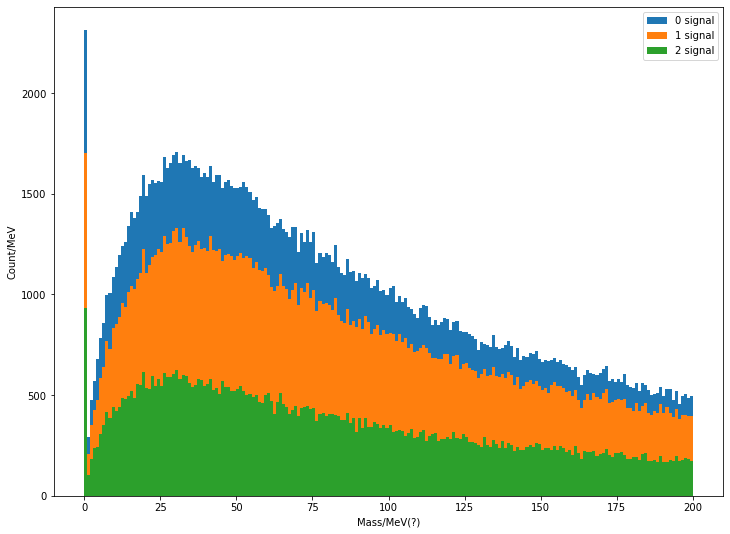

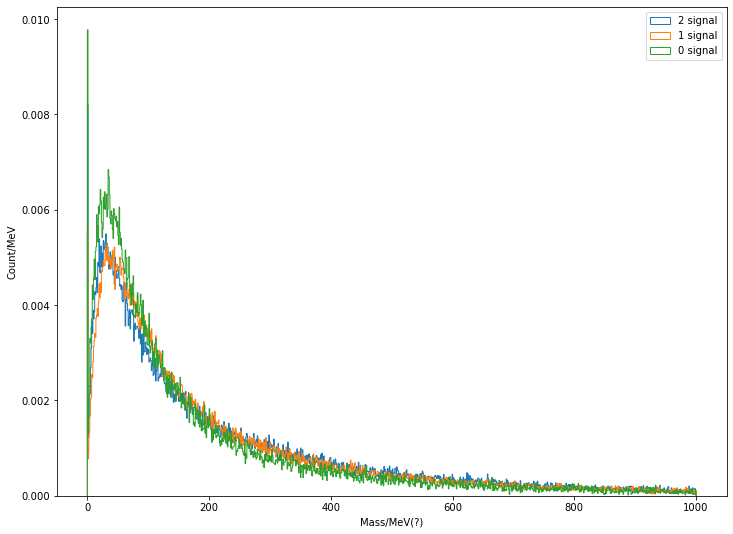

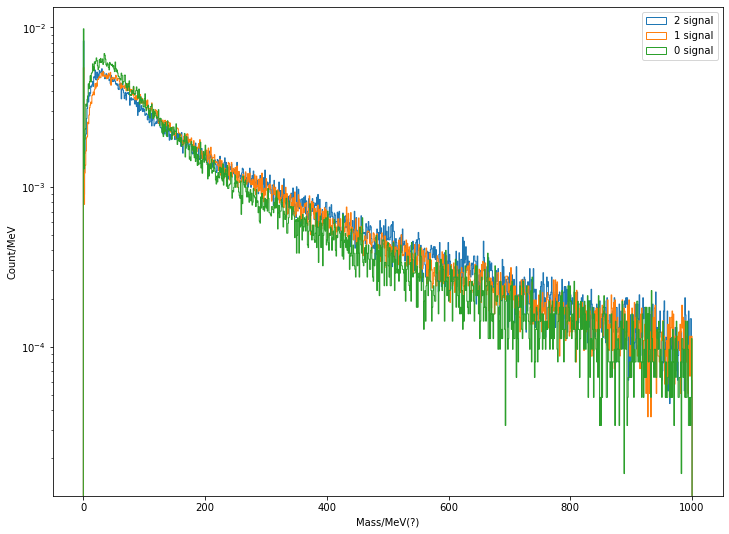

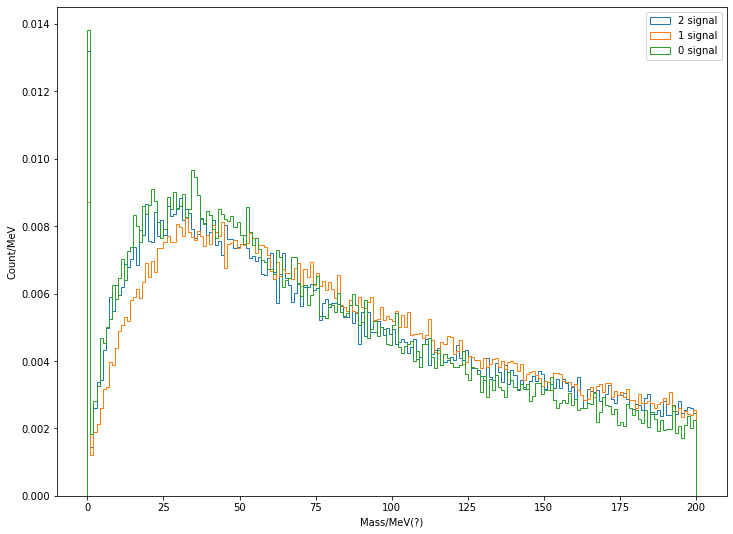

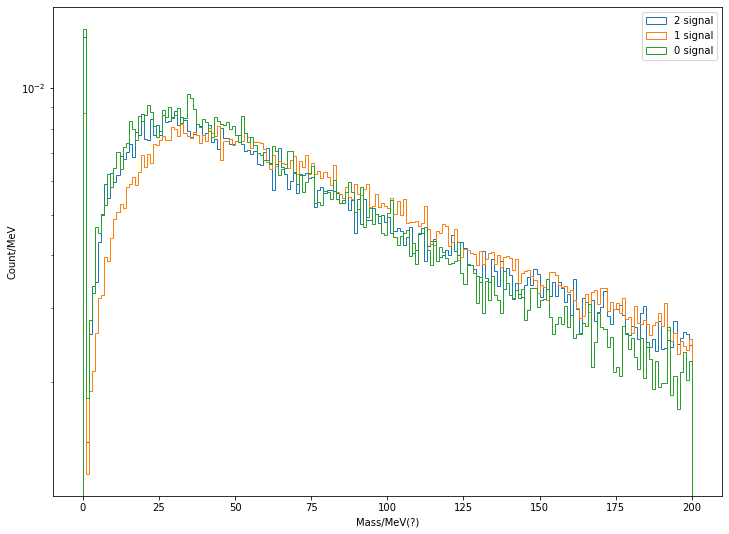

In [19]:
def paired_mass(pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    e = vector.magnitude(first_mom) + vector.magnitude(second_mom)
    p = vector.magnitude(vector.add(first_mom, second_mom))
    return np.sqrt(e**2 - p**2)

masses = paired_mass(pair_coords)

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses), bins=1000, range=(0,1000), label="0 signal")
plt.hist(ak.ravel(masses[sig_count != 0]), bins=1000, range=(0,1000), label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 2]), bins=1000, range=(0,1000), label="2 signal")
plt.legend()
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses), bins=200, range=(0,200), label="0 signal")
plt.hist(ak.ravel(masses[sig_count != 0]), bins=200, range=(0,200), label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 2]), bins=200, range=(0,200), label="2 signal")
plt.legend()
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), bins=1000, range=(0,1000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(masses[sig_count == 1]), bins=1000, range=(0,1000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 0]), bins=1000, range=(0,1000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), bins=1000, range=(0,1000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(masses[sig_count == 1]), bins=1000, range=(0,1000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 0]), bins=1000, range=(0,1000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(masses[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(masses[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(masses[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Mass/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

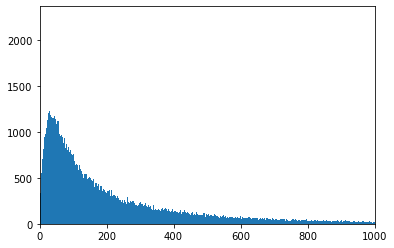

In [19]:
# This was a check to make sure the argument indexing worked properly
def paired_mass_old(paired_mom):
    e = vector.magnitude(paired_mom["0"]) + vector.magnitude(paired_mom["1"])
    p = vector.magnitude(vector.add(paired_mom["0"], paired_mom["1"]))
    return np.sqrt(e**2 - p**2)

plt.hist(ak.ravel(paired_mass_old(ak.combinations(events.recoParticles.momentum, 2))), bins=10000)
plt.xlim(0,1000)
plt.show()

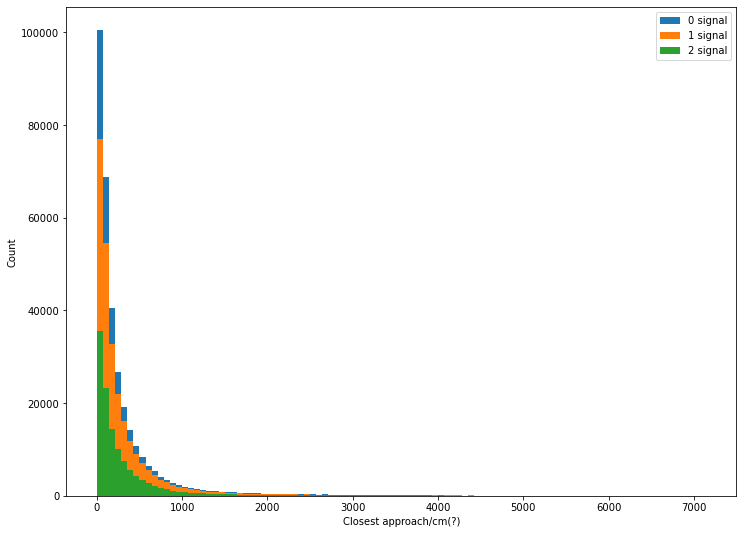

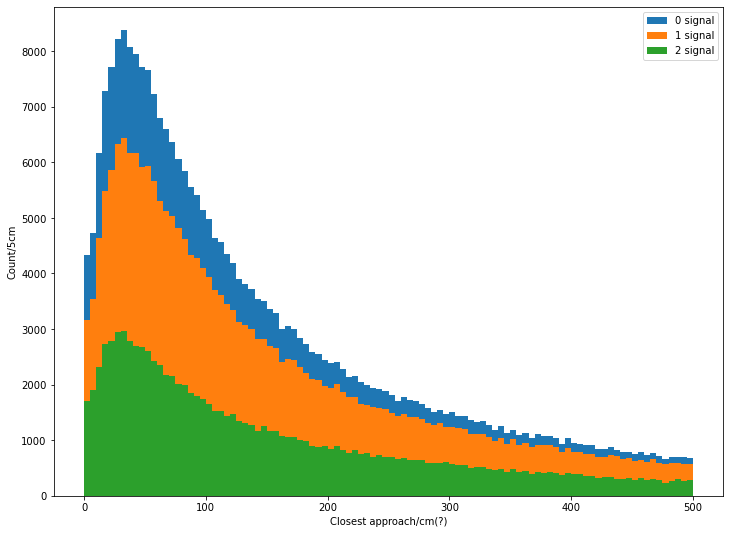

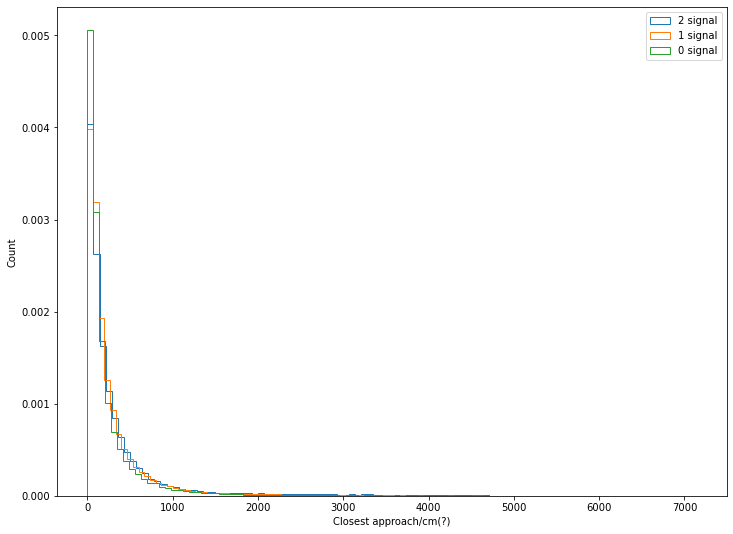

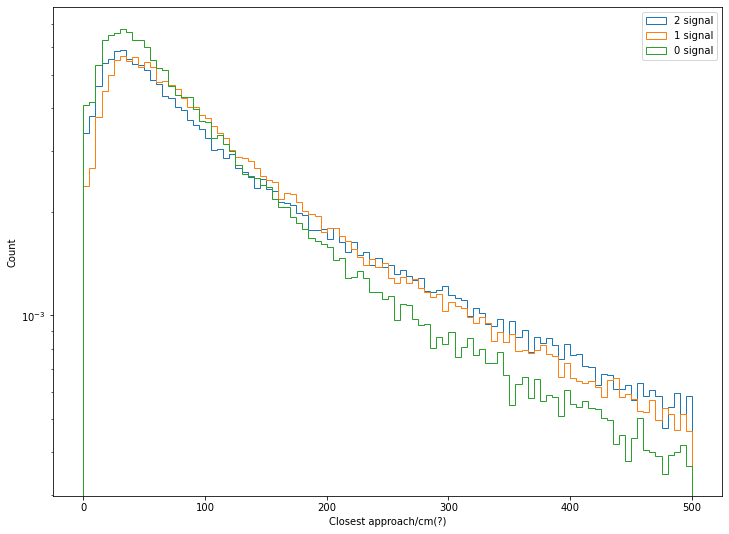

In [21]:
def closest_approach(dir1, dir2, start1, start2):
    """
    Find the closest approach between two showers.

    Parameters:
        Format: ak.zip({'x':ak.array, 'y':ak.array, 'z':ak.array})
            dir1    : direction of first shower
            dir2    : direction of second shower
            start1  : initial point of first shower
            start2  : initial point of second shower

    Returns:
        Format: ak.array
            d       : Magnitude of the sortest direction between the two showers
    """
    # x_1 - x_2 + lambda_1 v_1 - lambda_2 v_2 = d/sin(theta) v_1 x v_2
    cross = vector.normalize( vector.cross(dir1, dir2) )
    rel_start = vector.sub(start1, start2)

    # Separation between the lines
    d = vector.dot(rel_start, cross)

    return d

def paired_closest_appreach(pair_coords):
    # Get the momenta via the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    first_pos = events.recoParticles.startPos[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]
    second_pos = events.recoParticles.startPos[pair_coords["1"]]

    return closest_approach(first_dir,second_dir,first_pos,second_pos)

approaches = paired_mass(pair_coords)

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(approaches), label="0 signal", bins=100)
plt.hist(ak.ravel(approaches[sig_count != 0]), label="1 signal", bins=100)
plt.hist(ak.ravel(approaches[sig_count == 2]), label="2 signal", bins=100)
plt.legend()
plt.xlabel("Closest approach/cm(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(approaches), label="0 signal", bins=100, range=(0,500))
plt.hist(ak.ravel(approaches[sig_count != 0]), label="1 signal", bins=100, range=(0,500))
plt.hist(ak.ravel(approaches[sig_count == 2]), label="2 signal", bins=100, range=(0,500))
plt.legend()
plt.xlabel("Closest approach/cm(?)")
plt.ylabel("Count/5cm")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), histtype='step', density=True, label="2 signal", bins=100)
plt.hist(ak.ravel(masses[sig_count == 1]), histtype='step', density=True, label="1 signal", bins=100)
plt.hist(ak.ravel(masses[sig_count == 0]), histtype='step', density=True, label="0 signal", bins=100)
plt.legend()
plt.xlabel("Closest approach/cm(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(masses[sig_count == 2]), histtype='step', density=True, label="2 signal", bins=100, range=(0,500))
plt.hist(ak.ravel(masses[sig_count == 1]), histtype='step', density=True, label="1 signal", bins=100, range=(0,500))
plt.hist(ak.ravel(masses[sig_count == 0]), histtype='step', density=True, label="0 signal", bins=100, range=(0,500))
plt.legend()
plt.yscale('log')
plt.xlabel("Closest approach/cm(?)")
plt.ylabel("Count/5cm")
plt.show()


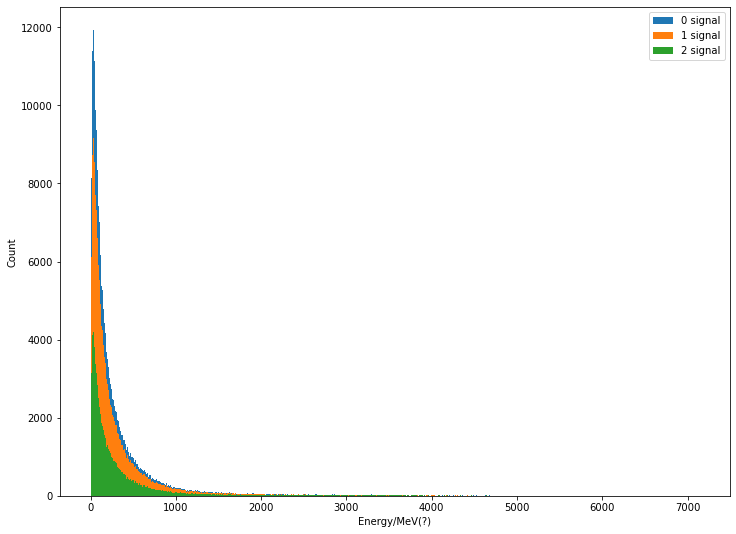

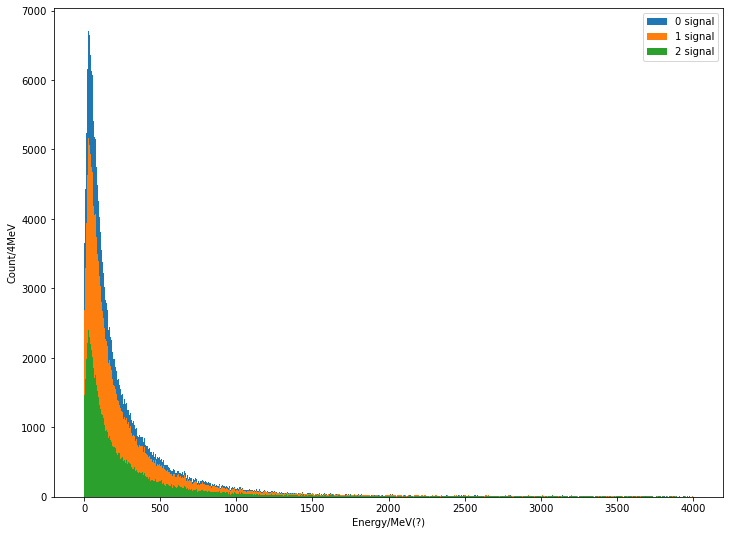

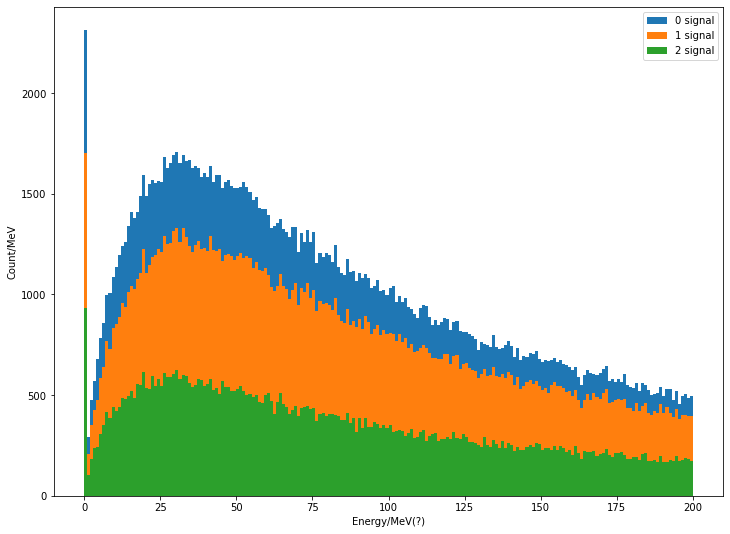

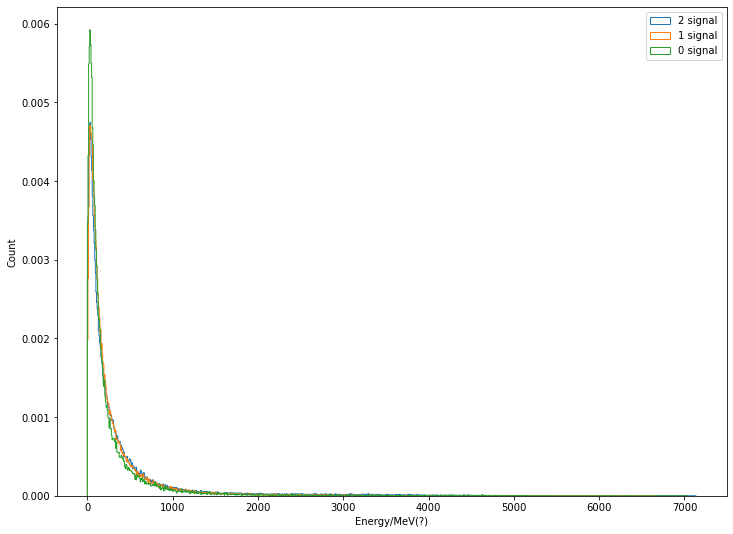

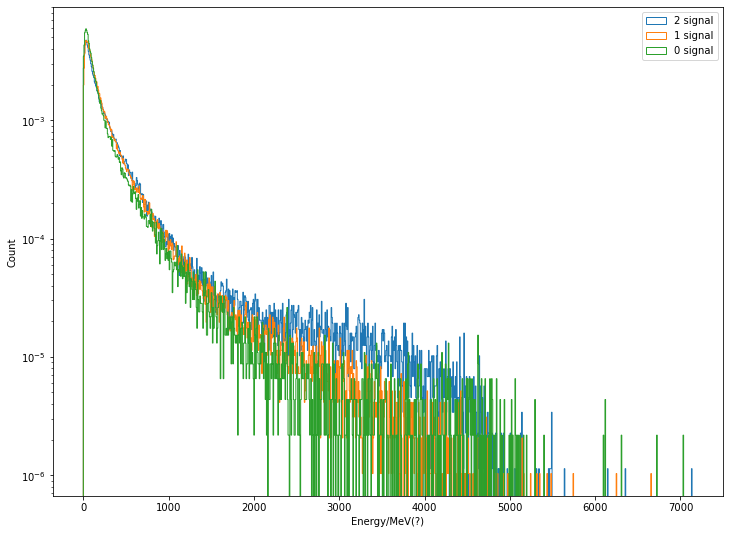

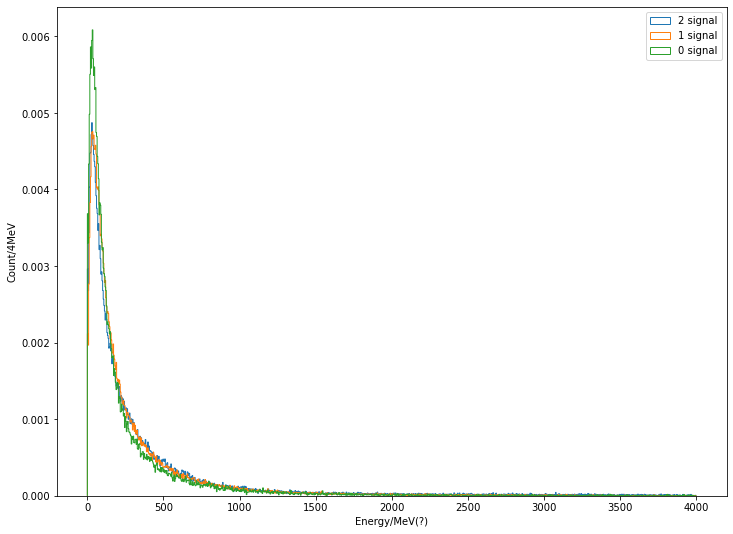

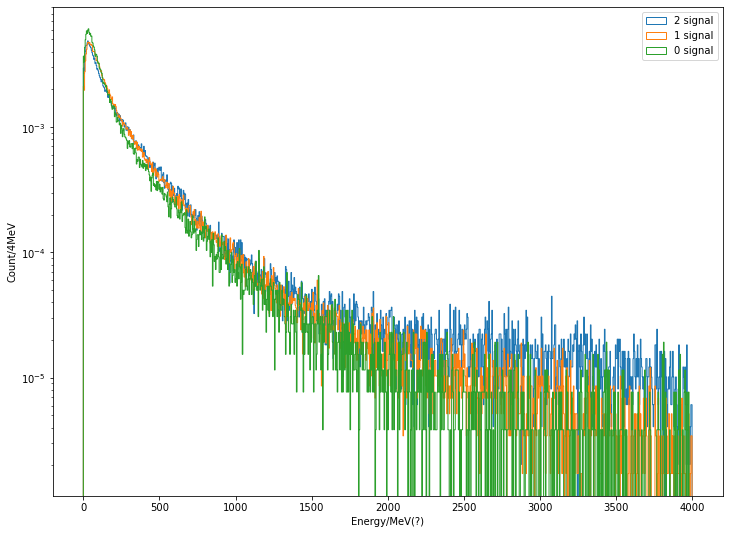

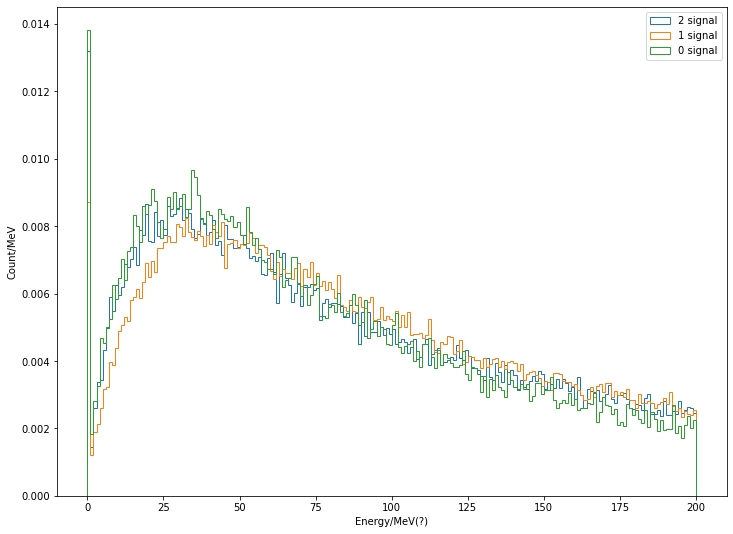

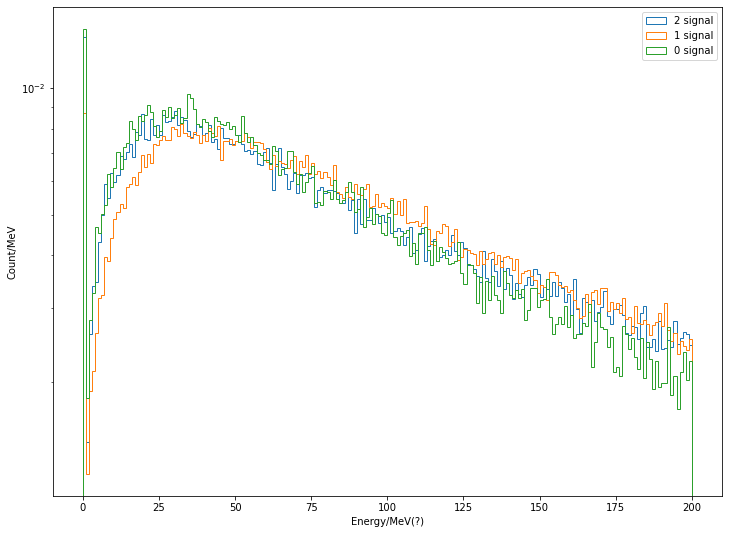

In [26]:
def paired_energy(pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.magnitude(first_mom) + vector.magnitude(second_mom)

energies = paired_mass(pair_coords)

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies), bins=1000, label="0 signal")
plt.hist(ak.ravel(energies[sig_count != 0]), bins=1000, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, label="2 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies), bins=1000, range=(0,4000), label="0 signal")
plt.hist(ak.ravel(energies[sig_count != 0]), bins=1000, range=(0,4000), label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, range=(0,4000), label="2 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies), bins=200, range=(0,200), label="0 signal")
plt.hist(ak.ravel(energies[sig_count != 0]), bins=200, range=(0,200), label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 2]), bins=200, range=(0,200), label="2 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=1000, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=1000, histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=1000, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=1000, histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, range=(0,4000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=1000, range=(0,4000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=1000, range=(0,4000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=1000, range=(0,4000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=1000, range=(0,4000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=1000, range=(0,4000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(energies[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(energies[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(energies[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Energy/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

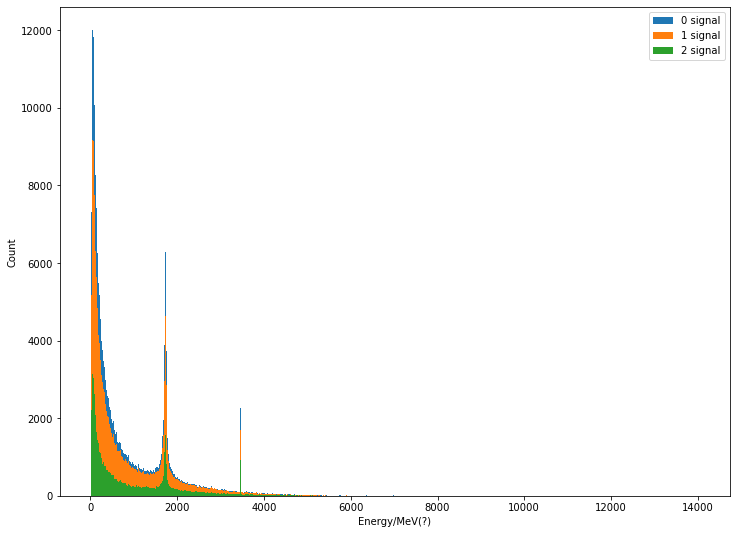

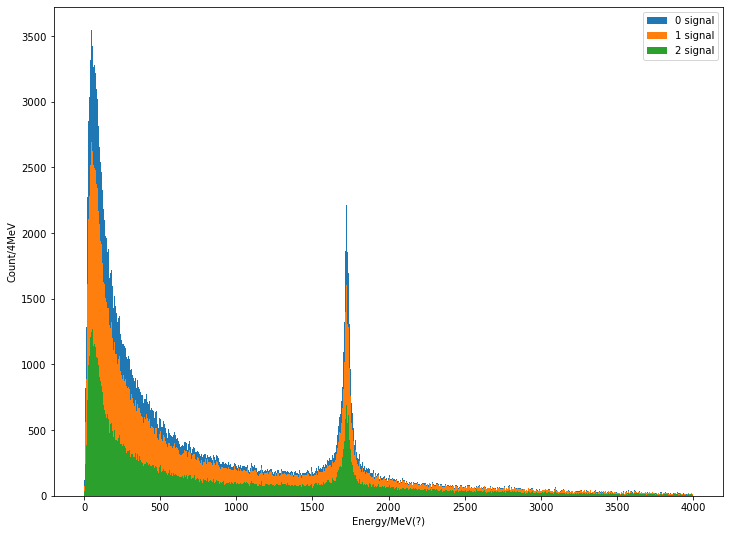

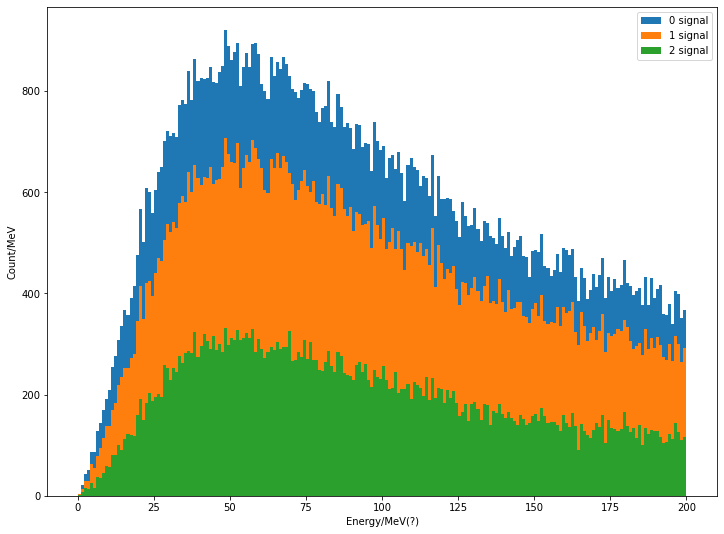

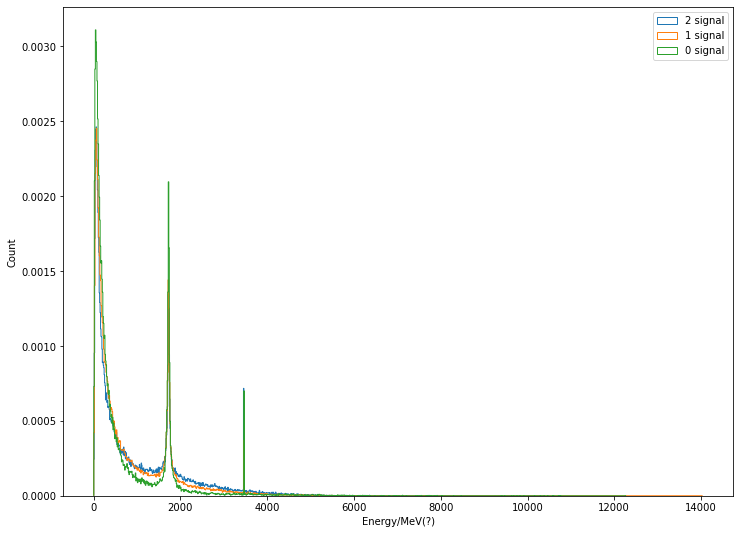

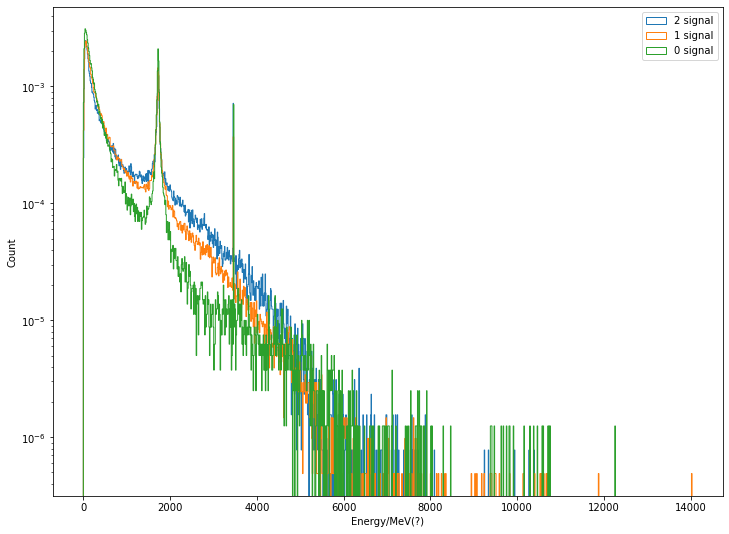

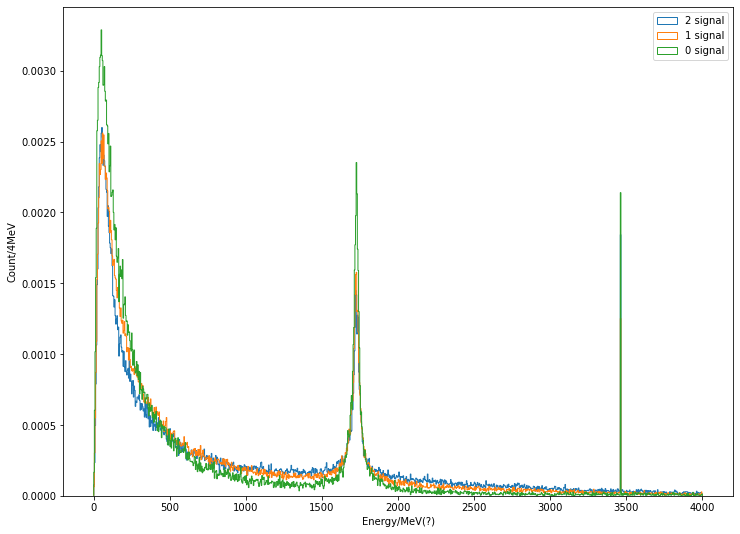

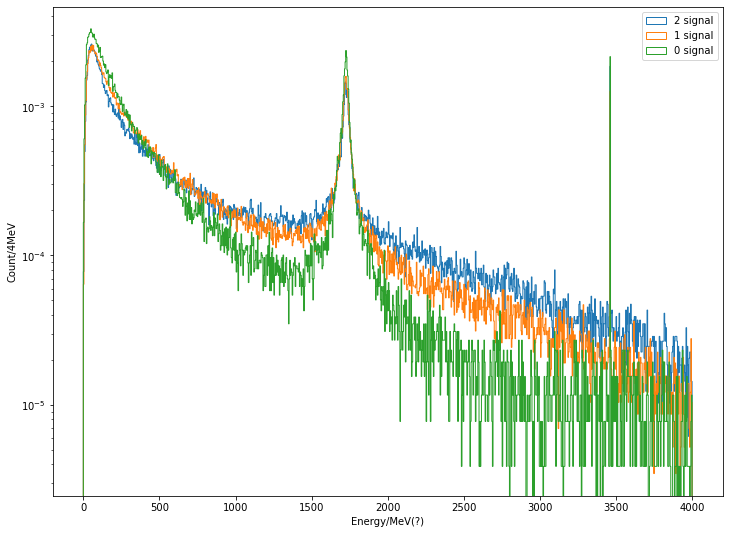

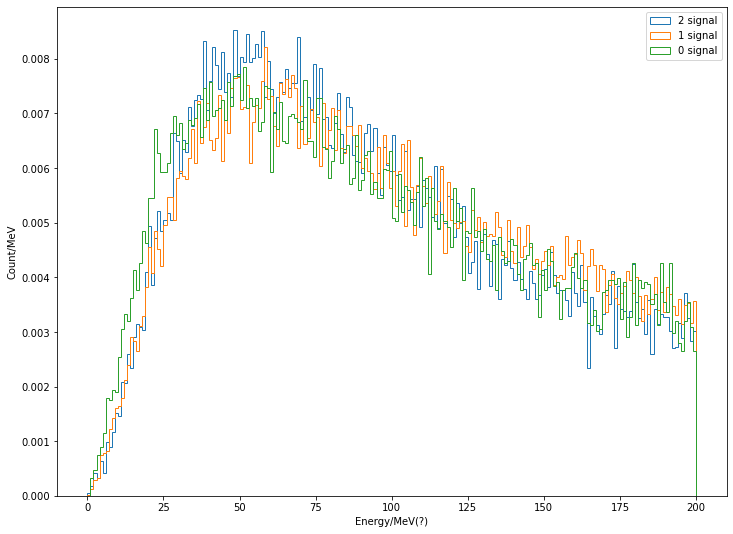

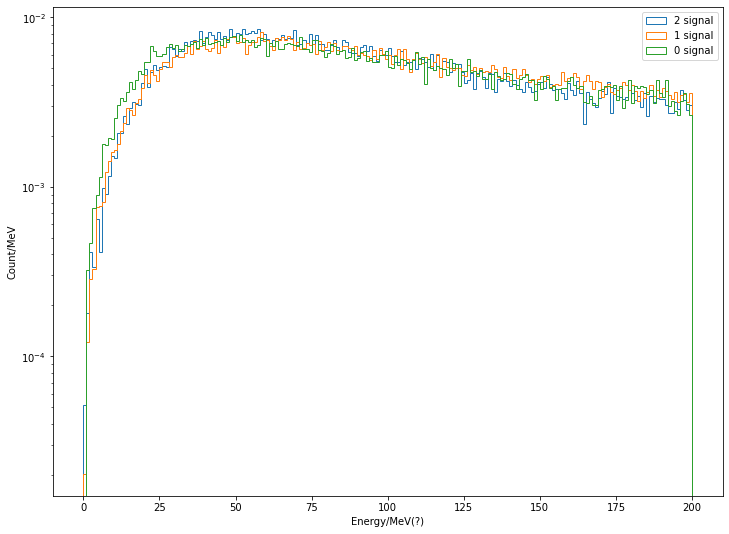

In [25]:
def paired_momentum(pair_coords):
    # Get the momenta via the pair indicies
    first_mom = events.recoParticles.momentum[pair_coords["0"]]
    second_mom = events.recoParticles.momentum[pair_coords["1"]]

    # Calculate
    return vector.add(first_mom, second_mom)

momentum = paired_momentum(pair_coords)
mom_mag = vector.magnitude(momentum)

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag), bins=1000, label="0 signal")
plt.hist(ak.ravel(mom_mag[sig_count != 0]), bins=1000, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, label="2 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag), bins=1000, range=(0,4000), label="0 signal")
plt.hist(ak.ravel(mom_mag[sig_count != 0]), bins=1000, range=(0,4000), label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, range=(0,4000), label="2 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag), bins=200, range=(0,200), label="0 signal")
plt.hist(ak.ravel(mom_mag[sig_count != 0]), bins=200, range=(0,200), label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=200, range=(0,200), label="2 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=1000, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=1000, histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=1000, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=1000, histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, range=(0,4000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=1000, range=(0,4000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=1000, range=(0,4000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=1000, range=(0,4000), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=1000, range=(0,4000), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=1000, range=(0,4000), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/4MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(mom_mag[sig_count == 2]), bins=200, range=(0,200), histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 1]), bins=200, range=(0,200), histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(mom_mag[sig_count == 0]), bins=200, range=(0,200), histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Momentum/MeV(?)")
plt.ylabel("Count/MeV")
plt.show()

/software/wx21978/miniconda/envs/pi0-phys/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(


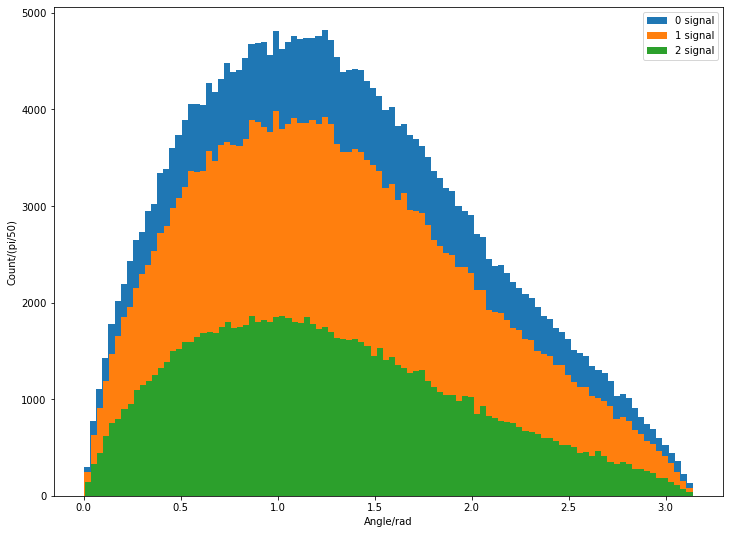

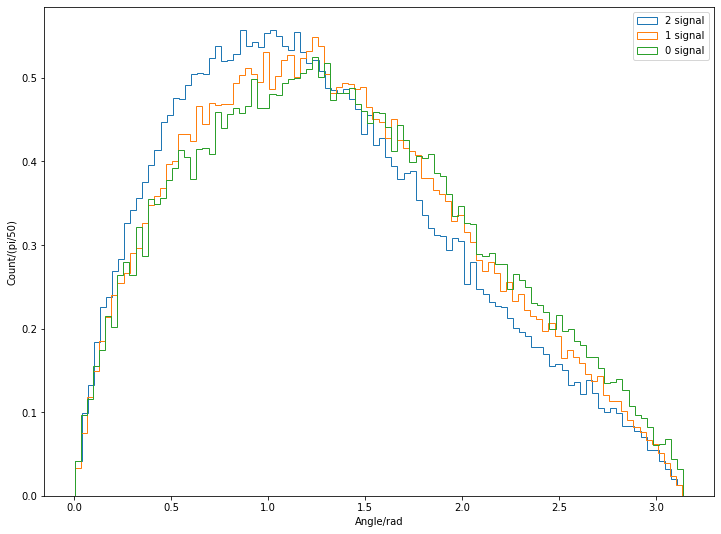

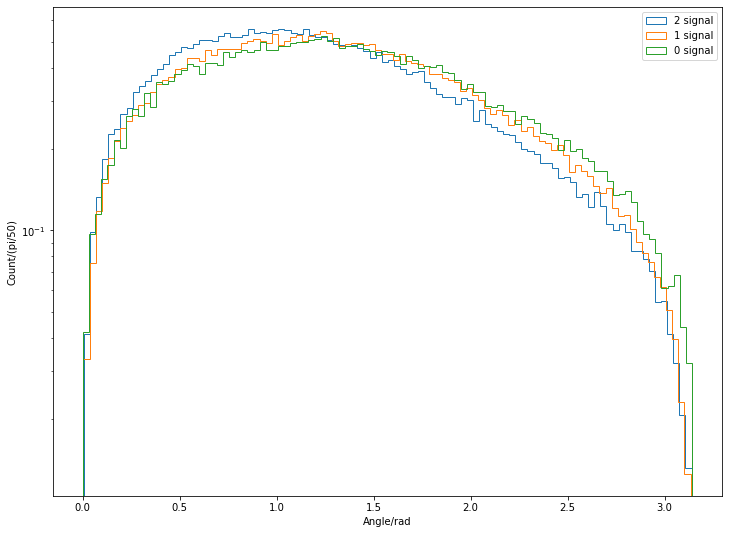

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/tmp/ipykernel_3735169/1733538581.py:51: RuntimeWarning: invalid value encountered in arccos
  bins[i+1] = np.arccos(np.max(np.cos(bins[i]) - 0.02, -1))


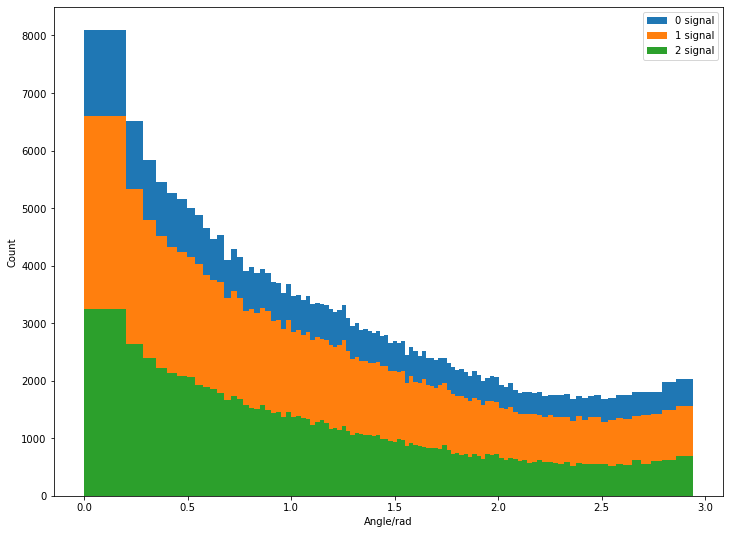

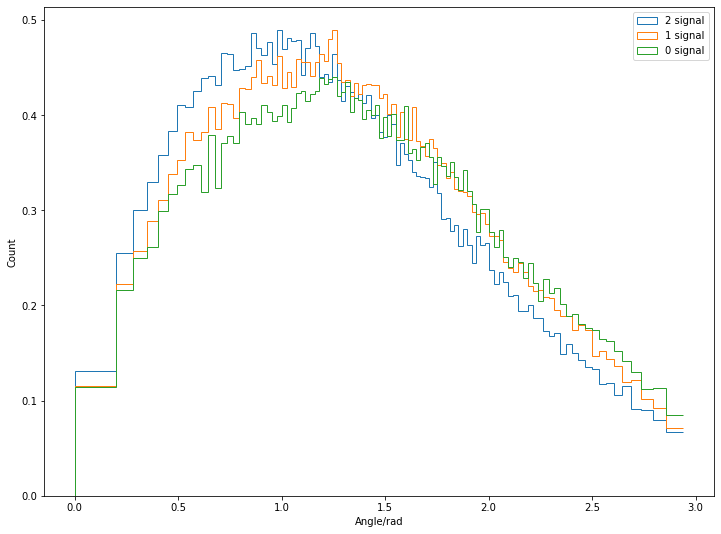

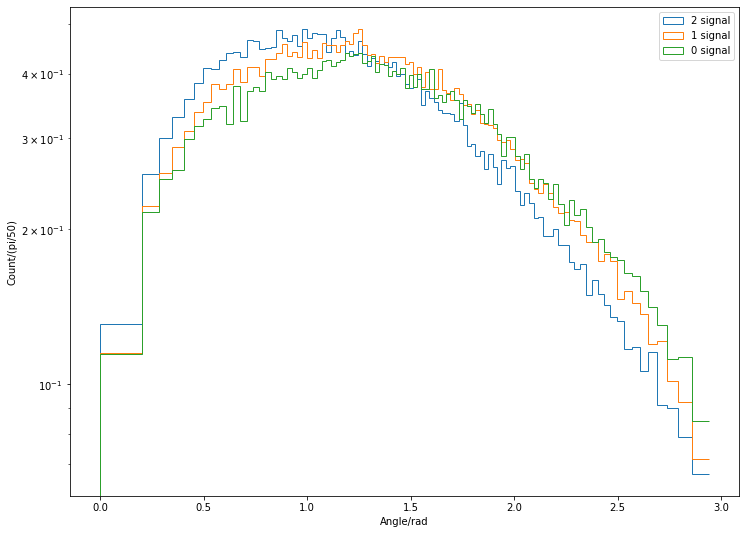

In [34]:
# N.B. this is phi in Shyam's scheme
def paired_opening_angle(pair_coords):
    # Get the momenta via the pair indicies
    first_dir = events.recoParticles.direction[pair_coords["0"]]
    second_dir = events.recoParticles.direction[pair_coords["1"]]

    # Calculate
    return np.arccos(vector.dot(first_dir, second_dir))

angles = paired_opening_angle(pair_coords)

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles), bins=100, label="0 signal")
plt.hist(ak.ravel(angles[sig_count != 0]), bins=100, label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 2]), bins=100, label="2 signal")
plt.legend()
plt.xlabel("Angle/rad")
plt.ylabel("Count/(pi/50)")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles[sig_count == 2]), bins=100, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(angles[sig_count == 1]), bins=100, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 0]), bins=100, histtype='step', density=True, label="0 signal")
plt.legend()
plt.xlabel("Angle/rad")
plt.ylabel("Count/(pi/50)")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles[sig_count == 2]), bins=100, histtype='step', density=True, label="2 signal")
plt.hist(ak.ravel(angles[sig_count == 1]), bins=100, histtype='step', density=True, label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 0]), bins=100, histtype='step', density=True, label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Angle/rad")
plt.ylabel("Count/(pi/50)")
plt.show()

# Weigth the bin widths to keep then with equal area on a sphere
# Area cover over angle dTheta is r sin(Theta) dTheta (with r=1)
# So we need constant sin(Theta) dTheta
# In the range Theta = [0, pi), we have
# \int^\pi_0 sin(\theta) d\theta = 2
# So for 100 bins, we need: sin(Theta) dTheta = 2/100 = 0.02
# \int^{\theta_new}_{\theta_old} sin(\theta) d\theta = 2/100
# So 0.2 = cons(theta_old) - cos(theta_new)
bins = np.zeros(101)
for i in range(100):
    print(i)
    bins[i+1] = np.arccos(np.max(np.cos(bins[i]) - 0.02, -1))

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles), bins=bins, label="0 signal")
plt.hist(ak.ravel(angles[sig_count != 0]), bins=bins, label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 2]), bins=bins, label="2 signal")
plt.legend()
plt.xlabel("Angle/rad")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles[sig_count == 2])/ak.sum(sig_count == 2), bins=bins, histtype='step', label="2 signal")
plt.hist(ak.ravel(angles[sig_count == 1])/ak.sum(sig_count == 1), bins=bins, histtype='step', label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 0])/ak.sum(sig_count == 0), bins=bins, histtype='step', label="0 signal")
plt.legend()
plt.xlabel("Angle/rad")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,9))
plt.hist(ak.ravel(angles[sig_count == 2])/ak.sum(sig_count == 2), bins=bins, histtype='step', label="2 signal")
plt.hist(ak.ravel(angles[sig_count == 1])/ak.sum(sig_count == 1), bins=bins, histtype='step', label="1 signal")
plt.hist(ak.ravel(angles[sig_count == 0])/ak.sum(sig_count == 0), bins=bins, histtype='step', label="0 signal")
plt.legend()
plt.yscale('log')
plt.xlabel("Angle/rad")
plt.ylabel("Count/(pi/50)")
plt.show()
